# Example: Static inverse free-boundary equilibrium calculations (in SPARC)

---

Here we will generate an equilibrium (find coil currents with the inverse solver) in a SPARC-like tokamak. 

The machine description comes from files located [here](https://github.com/cfs-energy/SPARCPublic).

The equilbirium\profile parameters are **completely made up** - please experiment on your own and change them to more realistic values as you please!

### Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/SPARC/SPARC_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/SPARC/SPARC_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/SPARC/SPARC_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/SPARC/SPARC_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No coil named Solenoid among the active coils.
No probe configuration is provided


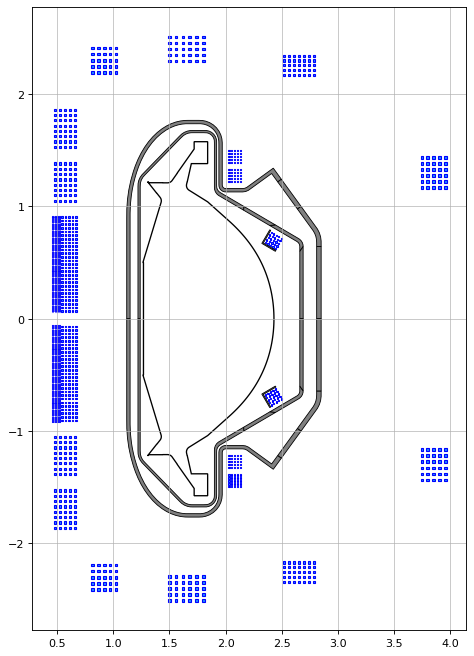

In [4]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter


### Instantiate an equilibrium

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=1.1, Rmax=2.7,   # radial range
    Zmin=-1.8, Zmax=1.8,  # vertical range
    nx=129,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,                # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=5e4,    # pressure on axis
    Ip=8.7e6,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

In [8]:
Rx = 1.55      # X-point radius
Zx = 1.15      # X-point height

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx, Rx], [Zx, -Zx]]

Rout = 2.4    # outboard midplane radius
Rin = 1.3    # inboard midplane radius

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, Rx, Rout, Rin, 1.7, 1.7], [Zx, -Zx, 0.0, 0.0, 1.5, -1.5]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

### The inverse solve

In [9]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     max_solving_iterations=500,
                     verbose=True, # print output
                     force_up_down_symmetric=True,
                     l2_reg=np.array([1e-16]*10 + [1e-16]), 
                     )
                     
                    #  GSStaticSolver.solve(eq=eq, 
                    #  profiles=profiles, 
                    #  constrain=constrain, 
                    #  target_relative_tolerance=1e-6,
                    #  verbose=True, # print output
                    #  picard=True, 
                    #  )

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:650: RuntimeWarning: divide by zero encountered in scalar divide
  rel_delta_psit /= np.linalg.norm(self.tokamak_psi)
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:976: RuntimeWarning: invalid value encountered in scalar multiply
  previous_rel_delta_psit = rel_delta_psit * adj_factor


The initial coil currents and initial plasma_psi are significantly mismatched!
Please ensure that sufficient isoflux constraints are provided (for example, try providing at least three non-aligned points on the LCFS).
Initial setup of the currents triggered. Relative update of tokamak_psi in the core of: inf
Current updates: [-3.26345514e+03 -4.94592982e+03 -4.45074812e+04  1.23284217e+04
  2.37245071e+04  1.91928977e+04 -1.55092272e+04  4.42440922e+03
 -3.53654543e+03 -9.71822079e+03  1.24575544e-10]
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: nan
Current updates: [-0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0.]
Magnetic constraint losses = 0.00915495212178963
Handing off to forward_solve. Requested tolerance: nan
Forward static solve complete. Last relative residual: 4.538194491048206
 
Iteration 1 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of:

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.00019208 with less than 1 iterations. Last relative psi change: 4.584096079150903.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.00012549226666666666 with less than 1 iterations. Last relative psi change: 4.528389556517229.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 8.198828088888886e-05 with less than 1 iterations. Last relative psi change: 4.371111125740886.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of

Iteration 4 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.018078415935999997
Current updates: [-1.81063442e+02 -1.59443621e+02 -3.27006919e+02  1.31248312e+02
  2.14953399e+02  1.85914694e+02 -2.61900455e+02 -4.94504003e+02
  8.54571606e+01  4.79155377e+01 -8.08495320e-13]
Magnetic constraint losses = 0.4651828012810162
Handing off to forward_solve. Requested tolerance: 5.35656768474074e-05
Iteration 5 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.017716847617279995
Current updates: [-1.87730850e+02 -1.50972270e+02 -1.04323220e+02  6.57991683e+01
  1.04531015e+02  1.39831437e+02 -1.63058533e+02 -6.00613524e+02
  1.30586599e+02  2.99793358e+01 -7.18812875e-13]
Magnetic constraint losses = 0.6408975549139749
Handing off to forward_solve. Requested tolerance: 3.499624220697283e-05
Iteration 6 complete.
---
Using Greens' Jacobian to o

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.499624220697283e-05 with less than 1 iterations. Last relative psi change: 3.9113281043147183.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.286421157522225e-05 with less than 1 iterations. Last relative psi change: 3.649668817316588.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.4937951562478535e-05 with less than 1 iterations. Last relative psi change: 3.3823606190422844.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative

Iteration 8 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.016674955242602995
Current updates: [-1.92893654e+02 -1.28131397e+02  3.33074445e+02 -6.37754909e+01
 -1.12039167e+02  5.33254517e+01  2.41903921e+01 -8.52110387e+02
  2.34786121e+02  7.01537188e+00 -6.50350451e-12]
Magnetic constraint losses = 1.2707949381721773
Handing off to forward_solve. Requested tolerance: 9.759461687485977e-06
Iteration 9 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.016341456137750933
Current updates: [-1.91969329e+02 -1.20808740e+02  4.40317726e+02 -9.59032969e+01
 -1.65086497e+02  3.33383471e+01  6.87541393e+01 -9.24261831e+02
  2.64331822e+02  4.04760850e+00 -9.22719715e-12]
Magnetic constraint losses = 1.5224946154958083
Handing off to forward_solve. Requested tolerance: 6.376181635824171e-06
Iteration 10 complete.
---
Using Greens' Jacobian to

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.376181635824171e-06 with less than 1 iterations. Last relative psi change: 2.856551183222316.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 4.165772002071792e-06 with less than 1 iterations. Last relative psi change: 2.604843271064322.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.721637708020238e-06 with less than 1 iterations. Last relative psi change: 2.3642382321516253.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative t

Iteration 12 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.015380447785202075
Current updates: [-1.84904211e+02 -9.87935678e+01  7.07850648e+02 -1.76899233e+02
 -2.97412118e+02 -1.40572522e+01  1.77782720e+02 -1.12382630e+03
  3.45859462e+02  1.54321291e+00 -1.22292947e-11]
Magnetic constraint losses = 2.4383833452179338
Handing off to forward_solve. Requested tolerance: 1.778136635906555e-06
Iteration 13 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.015072838829498034
Current updates: [-1.81428593e+02 -9.12776618e+01  7.85595390e+02 -2.00692552e+02
 -3.35898244e+02 -2.72304174e+01  2.08969986e+02 -1.18672169e+03
  3.71597710e+02  2.14661546e+00 -1.39743876e-11]
Magnetic constraint losses = 2.8072515644726086
Handing off to forward_solve. Requested tolerance: 1.1617159354589493e-06
Iteration 14 complete.
---
Using Greens' Jacobian

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.1617159354589493e-06 with less than 1 iterations. Last relative psi change: 1.9178449848202588.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.7190098835274767.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.526383851334453.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less th

Iteration 16 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.014186435323612913
Current updates: [-1.68778085e+02 -6.79156307e+01  1.00362426e+03 -2.67933740e+02
 -4.43851715e+02 -6.27919452e+01  2.95222387e+02 -1.37435368e+03
  4.48398381e+02  6.88391745e+00 -1.60477671e-11]
Magnetic constraint losses = 4.152458763691077
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 17 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.013902706617140655
Current updates: [-8.83977465e+01 -3.21992119e+01  5.79676381e+02 -1.56413797e+02
 -2.58390285e+02 -3.99260493e+01  1.74215151e+02 -7.75958363e+02
  2.56044746e+02  5.01869653e+00 -9.05450461e-12]
Magnetic constraint losses = 4.694982493519234
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 18 complete.
---
Using Greens' Jacobian to optimise.
Control currents upda

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.4368022752835867.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.2642896443576181.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.1018254409086612.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 20 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.013085116246399846
Current updates: [-1.31909127e+02 -5.35844954e+01  7.45969465e+02 -2.04421547e+02
 -3.15384669e+02  3.25096005e+01  2.01223943e+02 -1.34664542e+03
  4.34434316e+02 -2.10387914e+01 -1.58636870e-11]
Magnetic constraint losses = 6.052659882115598
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 21 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.012823413921471849
Current updates: [-1.27752473e+02 -4.13780195e+01  8.94242351e+02 -2.48343865e+02
 -3.89063975e+02  1.47084209e+00  2.57683191e+02 -1.45523265e+03
  4.79558736e+02 -1.13029917e+01 -1.76425085e-11]
Magnetic constraint losses = 6.7757890791489945
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 22 complete.
---
Using Greens' Jacobian to optimise.
Control currents upd

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.8105287687119866.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.6784577642857518.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.47167021267592635.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 24 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.01206929459557793
Current updates: [-5.55101674e+01  1.61216687e-01  6.83087091e+02 -1.94601714e+02
 -3.11626142e+02 -4.63436749e+01  2.18436796e+02 -9.10568463e+02
  3.15388026e+02  9.75736180e+00 -1.19264416e-11]
Magnetic constraint losses = 9.425949912439618
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 25 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.011827908703666372
Current updates: [-5.00555459e+01  8.12544101e+00  7.44952916e+02 -2.13560653e+02
 -3.43183542e+02 -6.08886580e+01  2.43216200e+02 -9.49281806e+02
  3.33287904e+02  1.49118663e+01 -1.26515152e-11]
Magnetic constraint losses = 10.529067807998311
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 26 complete.
---
Using Greens' Jacobian to optimise.
Control currents upda

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.44764996449684774.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40009288417229777.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.34905411236021355.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 28 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.011132333048621162
Current updates: [-4.58848704e+01 -2.50567030e+01  1.34208633e+02 -3.82793257e+01
 -3.90145425e+01  8.69298321e+01  7.51036988e+00 -5.94757876e+02
  1.79949912e+02 -2.85880635e+01 -7.25654707e-12]
Magnetic constraint losses = 7.911223956451857
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 29 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.010909686387648738
Current updates: [-4.31961233e+01 -3.23979847e+01 -2.38465489e+01  6.76753507e+00
  3.93256453e+01  1.24527928e+02 -5.27421522e+01 -4.99154249e+02
  1.39047512e+02 -4.07803639e+01 -6.06988904e-12]
Magnetic constraint losses = 7.154828100731089
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 30 complete.
---
Using Greens' Jacobian to optimise.
Control currents upda

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.23970489591850475.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.17934453479572315.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.11496433781896556.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 32 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.010268109550563892
Current updates: [-3.13051990e+01 -4.49091802e+01 -3.88806785e+02  1.09509785e+02
  2.19144810e+02  2.10634117e+02 -1.89464098e+02 -2.70413176e+02
  4.12923650e+01 -7.45291344e+01 -2.65406874e-12]
Magnetic constraint losses = 5.187016499362276
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 33 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.010062747359552614
Current updates: [-2.51224486e+01 -4.55247772e+01 -4.80196530e+02  1.34466631e+02
  2.63647781e+02  2.32301036e+02 -2.22431397e+02 -2.10369879e+02
  1.51376822e+01 -8.70639864e+01 -2.63966041e-12]
Magnetic constraint losses = 4.615758057818055
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.4122636667333098e-06.
  warnings.warn(


Iteration 34 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00986149241236156
Current updates: [-1.59476635e+01 -4.04196482e+01 -5.15183678e+02  1.42422721e+02
  2.79595709e+02  2.40784166e+02 -2.32760573e+02 -1.82300699e+02
  1.18103109e+00 -1.01115019e+02 -2.14743988e-12]
Magnetic constraint losses = 4.269219295196868
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 5.044497570988816e-07
 
Iteration 35 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009664262564114328
Current updates: [-1.58880578e+01 -4.00649626e+01 -5.09556128e+02  1.40880019e+02
  2.76572203e+02  2.38249907e+02 -2.30229215e+02 -1.80644838e+02
  1.32476974e+00 -9.99460250e+01 -2.12080569e-12]
Magnetic constraint losses = 4.26388725928214
Handing off to forward_solve. Requested tolerance: 1e-06
Forward

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 0.09718536598526034.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.028689229276055623.
  warnings.warn(


Iteration 56 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.006322899954358312
Current updates: [-1.54756988e+01 -3.15592017e+01 -3.61938883e+02  1.00400921e+02
  1.98413031e+02  1.76704568e+02 -1.66598782e+02 -1.61952865e+02
  1.19203358e+01 -6.99044048e+01 -1.55865097e-12]
Magnetic constraint losses = 4.466256924818426
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 57 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0061964419552711465
Current updates: [-1.25566809e+01 -2.39036818e+01 -2.72592802e+02  7.38842431e+01
  1.53651018e+02  1.56628309e+02 -1.31425763e+02 -2.19591524e+02
  3.73830808e+01 -6.35861700e+01 -2.70278361e-12]
Magnetic constraint losses = 5.111332789673101
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 0.09589184981044023.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.02879346883118241.
  warnings.warn(


Iteration 58 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.006072513116165724
Current updates: [-1.55557364e+01 -3.11397853e+01 -3.52866867e+02  9.80043527e+01
  1.93466893e+02  1.72030884e+02 -1.62439197e+02 -1.57045749e+02
  1.16065078e+01 -6.74096656e+01 -1.86134989e-12]
Magnetic constraint losses = 4.452907514574106
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 59 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.005951062853842408
Current updates: [-1.36698900e+01 -3.09411453e+01 -3.74163653e+02  1.03681412e+02
  2.03569665e+02  1.76394556e+02 -1.69050455e+02 -1.37254956e+02
  3.58041919e+00 -7.19059208e+01 -1.53316670e-12]
Magnetic constraint losses = 4.1594003808303714
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.6567994446371588e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 9.922025293233417e-07
 
Iteration 60 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00583204159676556
Current updates: [-1.35559109e+01 -3.05560330e+01 -3.68730711e+02  1.02185830e+02
  2.00634614e+02  1.73896020e+02 -1.66596501e+02 -1.35467902e+02
  3.64593455e+00 -7.07909476e+01 -1.83941012e-12]
Magnetic constraint losses = 4.156635433167065
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 2.761315725889398e-07
 
Iteration 61 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0057154007648302484
Current updates: [-1.34408699e+01 -3.01724755e+01 -3.63340581e+02  1.00701823e+02
  1.97722082e+02  1.71415151e+02 -1.64161280e+02 -1.33687247e+02
  3.70863863e+00 -6.96842726e+01 -1.93675861e-12]
Magnetic constraint losses = 4

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 2.3873687034835753.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.0652371801746079.
  warnings.warn(


Iteration 80 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0038935174616079975
Current updates: [-2.30135284e+01 -4.82429180e+01 -5.59942336e+02  1.55448783e+02
  3.05265918e+02  2.65880004e+02 -2.52877659e+02 -2.11365717e+02
  9.04594671e+00 -1.05245428e+02 -1.33460237e-12]
Magnetic constraint losses = 4.117652615296202
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 81 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0038156471123758375
Current updates: [-9.95265838e+00 -1.88356642e+01 -2.10927989e+02  5.76894191e+01
  1.17659516e+02  1.14340537e+02 -9.91727310e+01 -1.39149280e+02
  2.07667439e+01 -4.55859125e+01 -1.90451237e-12]
Magnetic constraint losses = 4.735081350599655
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 2.3355206975232843.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 2.2856922163645543.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.12516972727737216.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 82 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0037393341701283203
Current updates: [-2.44500938e+01 -4.86721022e+01 -5.46077252e+02  1.52254742e+02
  2.97717528e+02  2.57317784e+02 -2.47064406e+02 -2.00420855e+02
  7.79990336e+00 -9.87900226e+01 -2.07541718e-12]
Magnetic constraint losses = 4.103772529081217
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 83 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0036645474867257545
Current updates: [-2.20245375e+01 -3.96075256e+01 -4.25909451e+02  1.17163184e+02
  2.37489339e+02  2.28399208e+02 -2.00539772e+02 -2.73059593e+02
  4.02050826e+01 -8.81516084e+01 -2.86140248e-12]
Magnetic constraint losses = 4.721987905438673
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 84 complete.
---
Using Greens' Jacobian to optimise.
Control currents up

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 0.0004223202987811297.
  warnings.warn(


Iteration 86 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003449042778126386
Current updates: [-1.06974345e+01 -2.17428005e+01 -2.47719782e+02  6.88615604e+01
  1.35124986e+02  1.17688010e+02 -1.11825703e+02 -9.35552838e+01
  4.40843209e+00 -4.58512472e+01 -1.35685644e-12]
Magnetic constraint losses = 4.09746759326927
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 9.056844144761923e-07
 
Iteration 87 complete.
---
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0033800619225638584
Current updates: [-1.04694491e+01 -2.13298246e+01 -2.43423338e+02  6.76463773e+01
  1.32786481e+02  1.15735221e+02 -1.09857895e+02 -9.21589109e+01
  4.40343307e+00 -4.51675819e+01 -1.10323647e-12]
Magnetic constraint losses = 4.095617362773929
Handing off to forward_solve. Requested tolerance: 1e-06
Forwa

In [13]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     target_relative_tolerance=1e-6,
                     )

Forward static solve complete. Last relative residual: 8.127301071191576e-07
 


This equilibrium has not been solved: the separatrix can not be drawn.
Please solve first for a plot of the critical points.


(-2.0, 2.0)

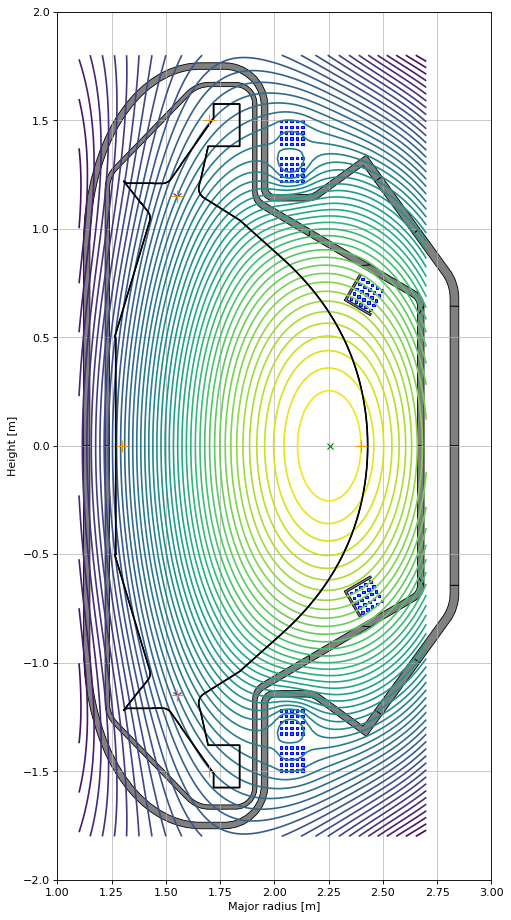

In [14]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax1,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax1, show=False)                                                          # plots the contraints
ax1.set_xlim(1.0, 3.0)
ax1.set_ylim(-2.0, 2.0)

In [11]:
eq.tokamak.getCurrents()

# # save coil currents to file
# import pickle
# with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
#     pickle.dump(obj=inverse_current_values, file=f)

{'CS1I': -8453.285010466283,
 'CS1O': -10071.773153853452,
 'CS2': -66742.23935622386,
 'CS3': 19030.704382336062,
 'PF1': 37685.92060360489,
 'PF2': 36008.92459303832,
 'PF3': -29353.580871120652,
 'PF4': -34520.69473582714,
 'DV1': 4900.562912094081,
 'DV2': -14631.651182442738,
 'VS1': -3.0639325589989463e-10,
 'vacuum_vessel_0': 0.0,
 'vacuum_vessel_1': 0.0,
 'vacuum_vessel_2': 0.0,
 'vacuum_vessel_3': 0.0,
 'vacuum_vessel_4': 0.0,
 'vacuum_vessel_5': 0.0,
 'vacuum_vessel_6': 0.0,
 'vacuum_vessel_7': 0.0,
 'vacuum_vessel_8': 0.0,
 'vacuum_vessel_9': 0.0,
 'vacuum_vessel_10': 0.0,
 'vacuum_vessel_11': 0.0,
 'vacuum_vessel_12': 0.0,
 'vacuum_vessel_13': 0.0,
 'vacuum_vessel_14': 0.0,
 'vacuum_vessel_15': 0.0,
 'VSC_coil_cover0': 0.0,
 'VSC_coil_cover1': 0.0}